**Import libraries**

In [1]:
# Base Libraries
import pandas as pd
import numpy as np


# Plotting
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (20,7)
# plt.style.use('fivethirtyeight')

# Classifier
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    TimeSeriesSplit,
                                    GridSearchCV
                                    )

# metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
                            accuracy_score,
                            f1_score,
                            log_loss,
                            RocCurveDisplay,
                            ConfusionMatrixDisplay,
                            classification_report
                            )


In [2]:
# load nifty index data
df = pd.read_csv(
    'https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv', 
    index_col=0, 
    parse_dates=True, 
    dayfirst=True
    )

df.head(5)

,Open,High,Low,Close,Volume
2012-01-02,4640.20,4645.95,4588.05,4636.75,108461000
2012-01-03,4675.80,4773.10,4675.80,4765.30,146621008
2012-01-04,4774.95,4782.85,4728.85,4749.65,165939008
2012-01-05,4749.00,4779.80,4730.15,4749.95,177863008
2012-01-06,4724.15,4794.90,4686.85,4754.10,176057008


In [3]:
# get info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2719 entries, 2012-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2719 non-null   float64
 1   High    2719 non-null   float64
 2   Low     2719 non-null   float64
 3   Close   2719 non-null   float64
 4   Volume  2719 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.5 KB


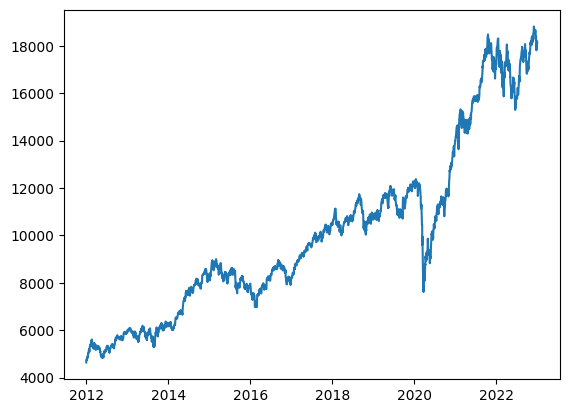

In [4]:
# Visualize data
plt.plot(df['Close']);

In [5]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2719.0,1.012490e+04,3.709607e+03,4640.20,7.637000e+03,9.376950e+03,1.170085e+04,1.887195e+04
High,2719.0,1.017529e+04,3.725527e+03,4645.95,7.681000e+03,9.431900e+03,1.175512e+04,1.888760e+04
Low,2719.0,1.005747e+04,3.685305e+03,4588.05,7.581650e+03,9.301350e+03,1.163133e+04,1.877820e+04
Close,2719.0,1.011757e+04,3.706945e+03,4636.75,7.623800e+03,9.351850e+03,1.168400e+04,1.881250e+04
Volume,2719.0,2.892221e+08,1.952768e+08,2826000.00,1.591780e+08,2.194961e+08,3.409088e+08,1.810971e+09


In [6]:
# Check for missing values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
# Predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low

X = df[['O-C', 'H-L']].values
X

array([[   3.45,   57.9 ],
       [ -89.5 ,   97.3 ],
       [  25.3 ,   54.  ],
       ...,
       [ -37.75,  104.75],
       [-145.3 ,  236.9 ],
       [ 153.8 ,  184.95]], shape=(2719, 2))

In [8]:
# specify label
# y =  np.where(df['Close'].shift(-1)>=df['UB'],1,0)
y = np.where(df['Close']>df['Close'].shift(1),1,0)

# check class imbalance
pd.Series(y).value_counts()

1    1465
0    1254
Name: count, dtype: int64

In [9]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 2175, 544


In [10]:
# Use pipeline to fit the basemodel
basemodel = Pipeline([
    ("scaler", StandardScaler()), 
    ("classifier", LogisticRegression(
        class_weight='balanced')) 
]) 

basemodel.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [11]:
# Predicting the test dataset
y_pred = basemodel.predict(X_test) # gives you the class labels 1, -1,..

# Predict Probabilities # gives you the probabilities of each class labels
y_proba = basemodel.predict_proba(X_test)

In [12]:
# verify the class labels
basemodel.classes_

array([0, 1])

In [13]:
# predict probability
y_proba[-20:]

array([[6.57998852e-01, 3.42001148e-01],
       [1.10141831e-01, 8.89858169e-01],
       [9.59176116e-01, 4.08238842e-02],
       [1.30214735e-01, 8.69785265e-01],
       [9.99266782e-01, 7.33217869e-04],
       [1.92247473e-02, 9.80775253e-01],
       [2.56988694e-02, 9.74301131e-01],
       [5.17473696e-01, 4.82526304e-01],
       [9.99826575e-01, 1.73425042e-04],
       [8.95440382e-01, 1.04559618e-01],
       [4.29177602e-03, 9.95708224e-01],
       [1.47621359e-01, 8.52378641e-01],
       [9.99967926e-01, 3.20736802e-05],
       [9.99106911e-01, 8.93089333e-04],
       [9.99440151e-01, 5.59848788e-04],
       [7.77439901e-04, 9.99222560e-01],
       [1.51379549e-01, 8.48620451e-01],
       [1.41009470e-01, 8.58990530e-01],
       [3.00479548e-03, 9.96995205e-01],
       [9.98443207e-01, 1.55679305e-03]])

In [14]:
# predict class labels
y_pred[-20:]

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0])

In [15]:
acc_train = accuracy_score(y_train, basemodel.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.8395, Test Accuracy: 0.8033


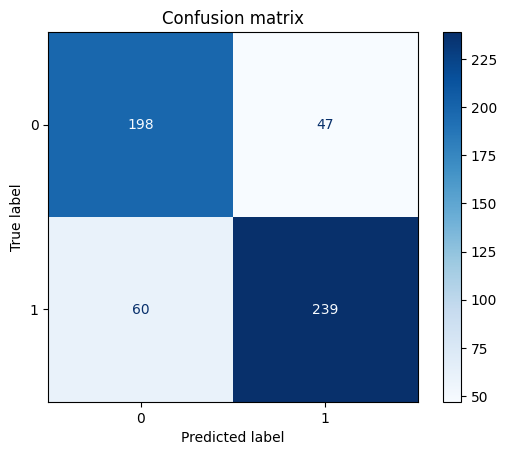

In [16]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        basemodel,
        X_test,
        y_test,
        # display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

In [17]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       245
           1       0.84      0.80      0.82       299

    accuracy                           0.80       544
   macro avg       0.80      0.80      0.80       544
weighted avg       0.80      0.80      0.80       544



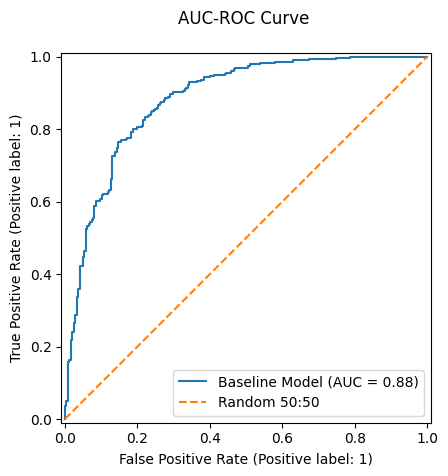

In [18]:
# Display ROCCurve 
disp = RocCurveDisplay.from_estimator(
            basemodel, 
            X_test, 
            y_test,
            name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [19]:
# Get parameters list
basemodel.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', LogisticRegression(class_weight='balanced'))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(class_weight='balanced'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 1.0,
 'classifier__class_weight': 'balanced',
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'deprecated',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [20]:
# Example: 
tscv = TimeSeriesSplit(n_splits=2, gap=1)
for train, test in tscv.split(X):
    print(train, test)  

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [21]:
# Perform Gridsearch and fit
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10]
    }

grid_search = GridSearchCV(
    estimator=basemodel, 
    param_grid=param_grid, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=tscv, 
    verbose=1)

# Fit the Model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1, param_grid={'classifier__C': [0.01, 0.1, 1, 10]},
             scoring='roc_auc', verbose=1)

In [22]:
# Get the Best Hyperparameters and Model
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'classifier__C': 1}


In [23]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict class labels 
y_pred = best_model.predict(X_test)

# Predict Probabilities
# y_proba = tunedmodel.predict_proba(X_test)[:,1]

# Measure Accuracy
acc_train = accuracy_score(y_train, best_model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.8395 
 Test Accuracy 		: 0.8033


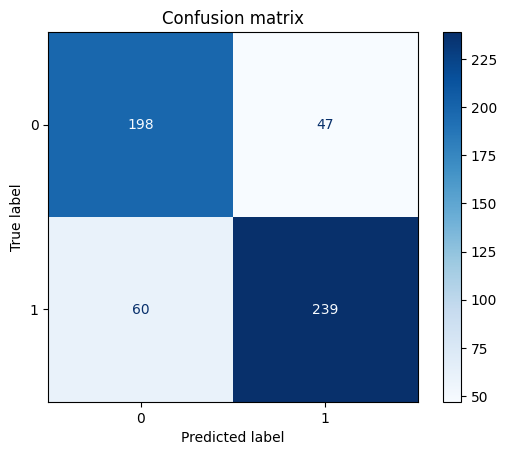

In [24]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        best_model,
        X_test,
        y_test,
        # display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

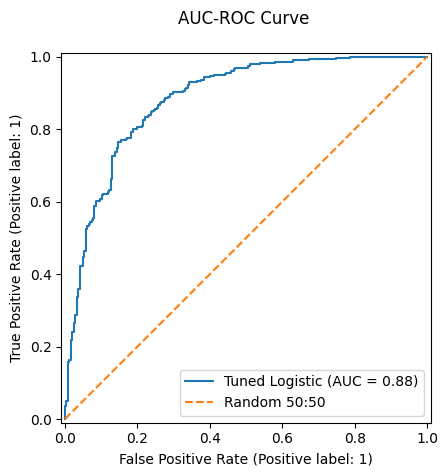

In [25]:
# Display ROCCurve 
disp = RocCurveDisplay.from_estimator(
            best_model, 
            X_test, 
            y_test,
            name='Tuned Logistic')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [26]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       245
           1       0.84      0.80      0.82       299

    accuracy                           0.80       544
   macro avg       0.80      0.80      0.80       544
weighted avg       0.80      0.80      0.80       544



**Trading Strategy**

In [27]:
# Subsume into a new dataframe
df1 = df.copy()                              # df[-len(X_test)
df1['Signal'] = best_model.predict(X)        # tunedmodel.predict(X_test)

In [28]:
# Daily Returns - Benchmark return
df1['Returns'] = np.log(df1['Close']).diff().fillna(0)

# Strategy Returns - Logistic
df1['Strategy'] =  df1['Returns'] * df1['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df1.index = df1.index.tz_localize('utc')

In [29]:
df1

,Open,High,Low,Close,Volume,O-C,H-L,Signal,Returns,Strategy
2012-01-02 00:00:00+00:00,4640.20,4645.95,4588.05,4636.75,108461000,3.45,57.90,1,0.000000,0.000000
2012-01-03 00:00:00+00:00,4675.80,4773.10,4675.80,4765.30,146621008,-89.50,97.30,1,0.027347,0.027347
2012-01-04 00:00:00+00:00,4774.95,4782.85,4728.85,4749.65,165939008,25.30,54.00,0,-0.003290,-0.003290
2012-01-05 00:00:00+00:00,4749.00,4779.80,4730.15,4749.95,177863008,-0.95,49.65,1,0.000063,0.000000
2012-01-06 00:00:00+00:00,4724.15,4794.90,4686.85,4754.10,176057008,-29.95,108.05,1,0.000873,0.000873
...,...,...,...,...,...,...,...,...,...,...
2022-12-26 00:00:00+00:00,17830.40,18084.10,17774.25,18014.60,176652336,-184.20,309.85,1,0.011602,0.000000
2022-12-27 00:00:00+00:00,18089.80,18149.25,17967.45,18132.30,214257088,-42.50,181.80,1,0.006512,0.006512
2022-12-28 00:00:00+00:00,18084.75,18173.10,18068.35,18122.50,193873168,-37.75,104.75,1,-0.000541,-0.000541
2022-12-29 00:00:00+00:00,18045.70,18229.70,17992.80,18191.00,281052832,-145.30,236.90,1,0.003773,0.003773


In [30]:
# Import pyfolio
import pyfolio as pf

import warnings
warnings.filterwarnings('ignore')

In [31]:
print(pf.__file__)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/__init__.py


Start date,2012-01-02
End date,2022-12-30
Total months,129
,Backtest
Annual return,10.2%
Cumulative returns,185.0%
Annual volatility,12.5%
Sharpe ratio,0.84
Calmar ratio,0.31
Stability,0.84
Max drawdown,-32.4%


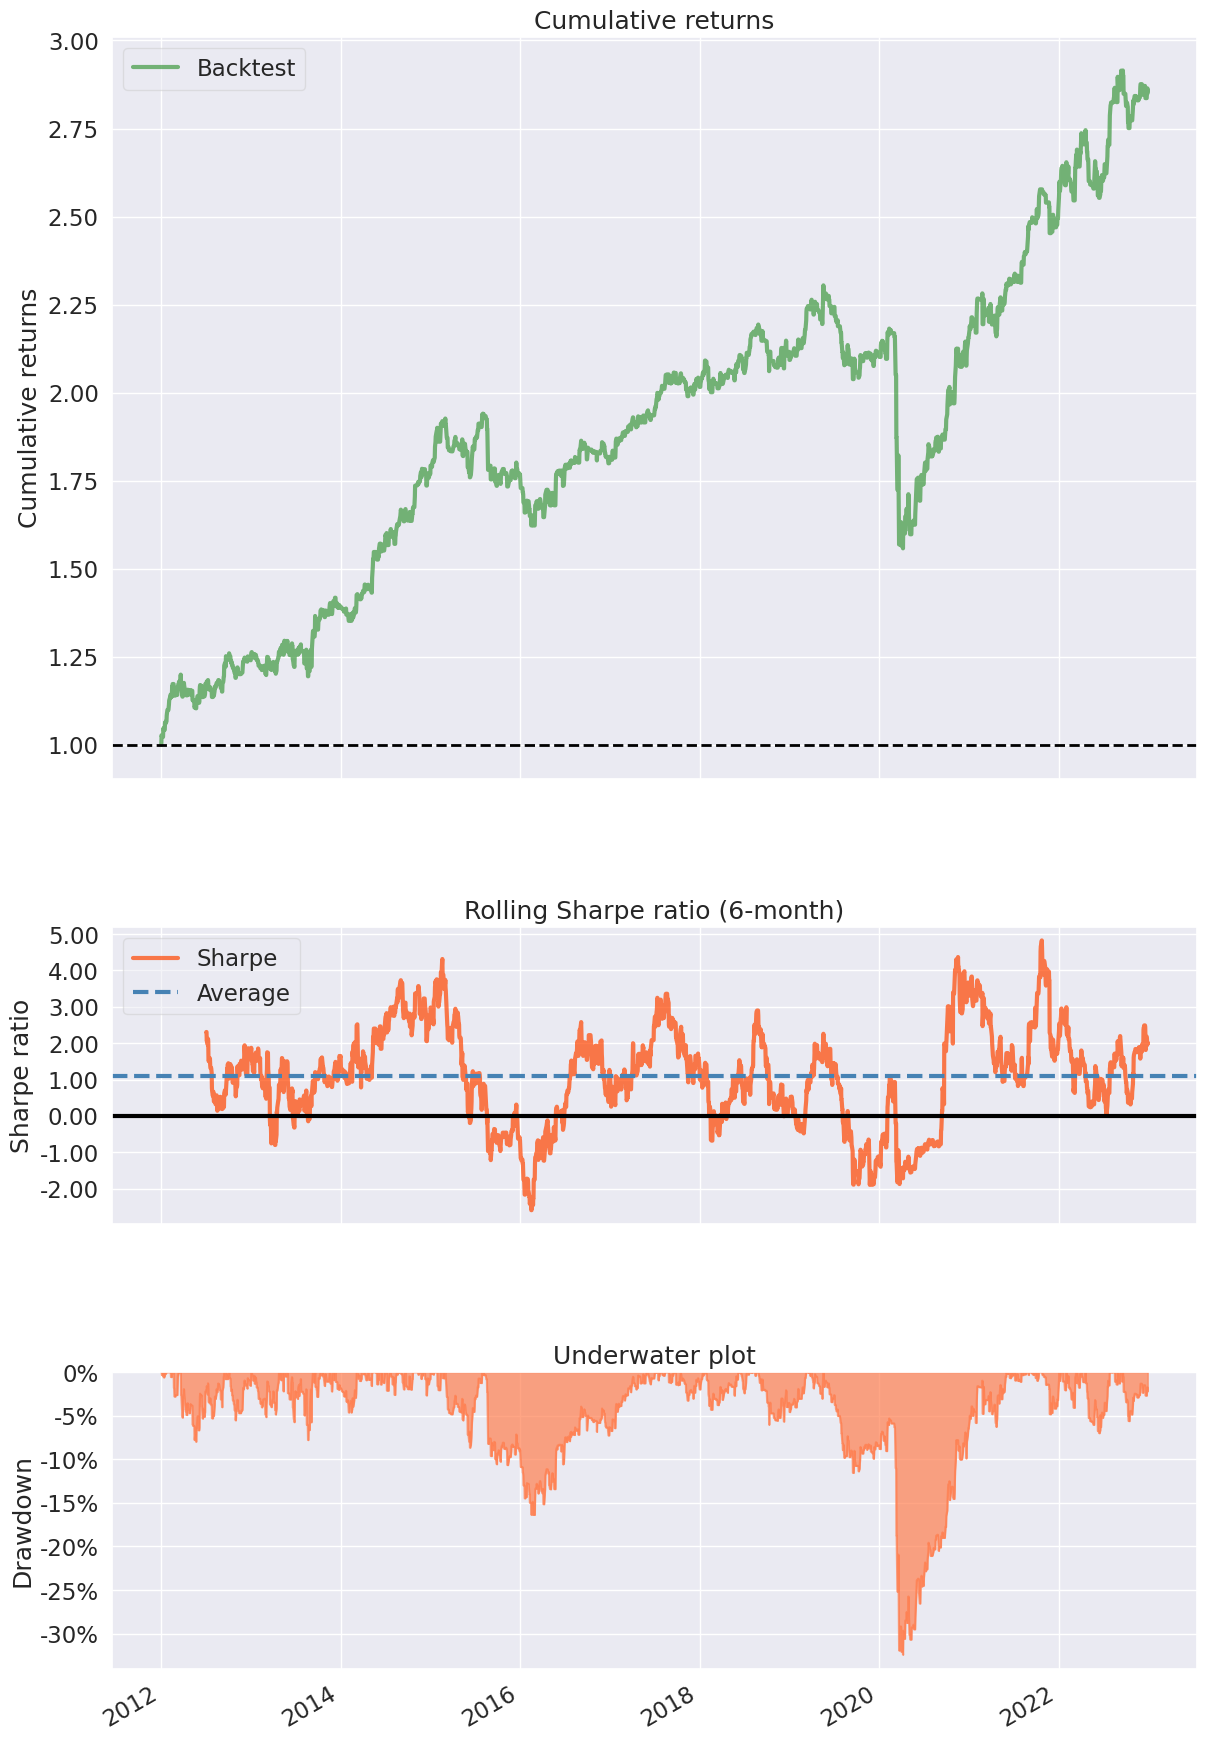

In [32]:
# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(df1['Strategy'])

In [42]:
# Live start date 2016-04-07
df1.index = pd.to_datetime(df1.index, errors='coerce')
pf.create_returns_tear_sheet(df1['Strategy'][:500], live_start_date='2020-04-07', benchmark_rets=df1['Returns'])

KeyError: np.int64(95)

In [40]:
print(df1.index.dtype)

datetime64[ns, UTC]


In [45]:
print(94 in df1.index)

False
